In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 589ms/step - loss: 0.2932
Average validation loss: 0.5104283094406128
4/4 [==============================] - 6s 607ms/step - loss: 0.2932 - val_loss: 0.5104
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 590ms/step - loss: 0.2260 - val_loss: 0.5104
Average validation loss: 0.5064942836761475
4/4 [==============================] - 9s 605ms/step - loss: 0.2260 - val_loss: 0.5085
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 577ms/step - loss: 0.1864 - val_loss: 0.5085
Average validation loss: 0.441110223531723
4/4 [==============================] - 11s 594ms/step - loss: 0.1864 - val_loss: 0.4860
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\Rip

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 558ms/step - loss: 0.0160
Average validation loss: 0.0007287769403774291
8/8 [==============================] - 5s 569ms/step - loss: 0.0160 - val_loss: 7.2878e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 9s 546ms/step - loss: 0.0155 - val_loss: 7.2878e-04
Average validation loss: 6.963309715501964e-05
8/8 [==============================] - 9s 558ms/step - loss: 0.0155 - val_loss: 3.9921e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 13s 549ms/step - loss: 0.0153 - val_loss: 3.9921e-04
Average validation loss: 0.0
8/8 [==============================] - 14s 560ms/step - loss: 0.0153 - val_loss: 2.6614e-04
Saved model weights to 'c:\Users\user\Desktop\天_11

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 7s 565ms/step - loss: 0.0203
Average validation loss: 0.10425269834134572
12/12 [==============================] - 7s 576ms/step - loss: 0.0203 - val_loss: 0.1043
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 14s 562ms/step - loss: 0.0191 - val_loss: 0.1043
Average validation loss: 0.035786333590901144
12/12 [==============================] - 14s 572ms/step - loss: 0.0191 - val_loss: 0.0700
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 21s 559ms/step - loss: 0.0186 - val_loss: 0.0700
Average validation loss: 0.021197558283650626
12/12 [==============================] - 21s 569ms/step - loss: 0.0186 - val_loss: 0.0537
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 9s 564ms/step - loss: 0.0132
Average validation loss: 0.031734158808831125
16/16 [==============================] - 9s 573ms/step - loss: 0.0132 - val_loss: 0.0317
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 18s 563ms/step - loss: 0.0139 - val_loss: 0.0317
Average validation loss: 0.02240295851515839
16/16 [==============================] - 18s 573ms/step - loss: 0.0139 - val_loss: 0.0271
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 27s 557ms/step - loss: 0.0134 - val_loss: 0.0271
Average validation loss: 0.059108557645231485
16/16 [==============================] - 27s 567ms/step - loss: 0.0134 - val_loss: 0.0377
Epoch 4/10
16/16 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 11s 562ms/step - loss: 0.0087
Average validation loss: 0.07118579298276018
20/20 [==============================] - 11s 572ms/step - loss: 0.0087 - val_loss: 0.0712
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 23s 567ms/step - loss: 0.0086 - val_loss: 0.0712
Average validation loss: 0.026285387389429538
20/20 [==============================] - 23s 576ms/step - loss: 0.0086 - val_loss: 0.0487
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 34s 562ms/step - loss: 0.0081 - val_loss: 0.0487
Average validation loss: 0.025111918661878008
20/20 [==============================] - 34s 572ms/step - loss: 0.0081 - val_loss: 0.0409
Saved model weights to 'c:\Users\user\De

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 14s 566ms/step - loss: 0.0110
Average validation loss: 0.026622281409800053
24/24 [==============================] - 14s 576ms/step - loss: 0.0110 - val_loss: 0.0266
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 27s 565ms/step - loss: 0.0096 - val_loss: 0.0266
Average validation loss: 0.03063490428030491
24/24 [==============================] - 28s 575ms/step - loss: 0.0096 - val_loss: 0.0286
Epoch 3/10
24/24 [==============================] - 41s 568ms/step - loss: 0.0090 - val_loss: 0.0286
Average validation loss: 0.016592316329479218
24/24 [==============================] - 42s 578ms/step - loss: 0.0090 - val_loss: 0.0246
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_30.pth'.
Epoch 4/10
24/24 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 23s 569ms/step - loss: 0.0146
Average validation loss: 0.025947324838489293
40/40 [==============================] - 23s 579ms/step - loss: 0.0146 - val_loss: 0.0259
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 46s 565ms/step - loss: 0.0125 - val_loss: 0.0259
Average validation loss: 0.03171828044578433
40/40 [==============================] - 46s 575ms/step - loss: 0.0125 - val_loss: 0.0288
Epoch 3/10
40/40 [==============================] - 69s 564ms/step - loss: 0.0114 - val_loss: 0.0288
Average validation loss: 0.022368529252707957
40/40 [==============================] - 69s 573ms/step - loss: 0.0114 - val_loss: 0.0267
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_50.pth'.
Epoch 4/10
40/40 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 27s 568ms/step - loss: 0.0102
Average validation loss: 0.015803690689305466
48/48 [==============================] - 28s 578ms/step - loss: 0.0102 - val_loss: 0.0158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 55s 565ms/step - loss: 0.0085 - val_loss: 0.0158
Average validation loss: 0.012222668039612472
48/48 [==============================] - 55s 574ms/step - loss: 0.0085 - val_loss: 0.0140
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 83s 568ms/step - loss: 0.0076 - val_loss: 0.0140
Average validation loss: 0.01037477059677864
48/48 [==============================] - 83s 577ms/step - loss: 0.0076 - val_loss: 0.0128
Saved model weights to 'c:\Users\user\De

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 32s 567ms/step - loss: 0.0097
Average validation loss: 0.01436565546984119
56/56 [==============================] - 32s 576ms/step - loss: 0.0097 - val_loss: 0.0144
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 64s 565ms/step - loss: 0.0076 - val_loss: 0.0144
Average validation loss: 0.017620905867910812
56/56 [==============================] - 64s 574ms/step - loss: 0.0076 - val_loss: 0.0160
Epoch 3/10
56/56 [==============================] - 96s 562ms/step - loss: 0.0065 - val_loss: 0.0160
Average validation loss: 0.013323352805205755
56/56 [==============================] - 96s 571ms/step - loss: 0.0065 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_70.pth'.
Epoch 4/10
56/56 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 36s 568ms/step - loss: 0.0062
Average validation loss: 0.008258890200522728
64/64 [==============================] - 37s 577ms/step - loss: 0.0062 - val_loss: 0.0083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 73s 565ms/step - loss: 0.0052 - val_loss: 0.0083
Average validation loss: 0.008843481962685473
64/64 [==============================] - 74s 574ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 3/10
64/64 [==============================] - 110s 566ms/step - loss: 0.0046 - val_loss: 0.0086
Average validation loss: 0.008535931890946813
64/64 [==============================] - 111s 575ms/step - loss: 0.0046 - val_loss: 0.0085
Epoch 4/10
64/64 [==============================] - 147s 563ms/step - loss: 0.0041 - val_loss: 0.0085
Average validation loss: 0.009299489684053697
64/64 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 41s 569ms/step - loss: 0.0069
Average validation loss: 0.009340145327668224
72/72 [==============================] - 42s 579ms/step - loss: 0.0069 - val_loss: 0.0093
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 83s 570ms/step - loss: 0.0053 - val_loss: 0.0093
Average validation loss: 0.0257984795090225
72/72 [==============================] - 83s 579ms/step - loss: 0.0053 - val_loss: 0.0176
Epoch 3/10
72/72 [==============================] - 124s 564ms/step - loss: 0.0047 - val_loss: 0.0176
Average validation loss: 0.01098463421739224
72/72 [==============================] - 125s 573ms/step - loss: 0.0047 - val_loss: 0.0154
Epoch 4/10
72/72 [==============================] - 165s 565ms/step - loss: 0.0044 - val_loss: 0.0154
Average validation loss: 0.010833459789864719
72/72 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 45s 563ms/step - loss: 0.0066
Average validation loss: 0.009886315348558128
80/80 [==============================] - 46s 572ms/step - loss: 0.0066 - val_loss: 0.0099
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 91s 567ms/step - loss: 0.0051 - val_loss: 0.0099
Average validation loss: 0.007680509239435196
80/80 [==============================] - 92s 576ms/step - loss: 0.0051 - val_loss: 0.0088
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 137s 567ms/step - loss: 0.0044 - val_loss: 0.0088
Average validation loss: 0.007624994305660948
80/80 [==============================] - 138s 576ms/step - loss: 0.0044 - val_loss: 0.0084
Saved model weights to 'c:\Users\us

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 54s 564ms/step - loss: 0.0090
Average validation loss: 0.020219038934252847
96/96 [==============================] - 55s 573ms/step - loss: 0.0090 - val_loss: 0.0202
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 109s 563ms/step - loss: 0.0069 - val_loss: 0.0202
Average validation loss: 0.019400131461831432
96/96 [==============================] - 110s 572ms/step - loss: 0.0069 - val_loss: 0.0198
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 164s 566ms/step - loss: 0.0056 - val_loss: 0.0198
Average validation loss: 0.021971901005599648
96/96 [==============================] - 165s 575ms/step - loss: 0.0056 - val_loss: 0.0205
Epoch 4/10
96/96 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 68s 563ms/step - loss: 0.0062
Average validation loss: 0.005810555134219916
120/120 [==============================] - 69s 573ms/step - loss: 0.0062 - val_loss: 0.0058
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 136s 563ms/step - loss: 0.0050 - val_loss: 0.0058
Average validation loss: 0.006723000591561382
120/120 [==============================] - 137s 572ms/step - loss: 0.0050 - val_loss: 0.0063
Epoch 3/10
120/120 [==============================] - 205s 563ms/step - loss: 0.0042 - val_loss: 0.0063
Average validation loss: 0.007527884610397943
120/120 [==============================] - 206s 573ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 4/10
120/120 [==============================] - 274s 568ms/step - loss: 0.0038 - val_loss: 0.0067
Average validation loss: 0.006427109880274884
120/120 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 81s 564ms/step - loss: 0.0050
Average validation loss: 0.00809980665993256
144/144 [==============================] - 83s 573ms/step - loss: 0.0050 - val_loss: 0.0081
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 164s 566ms/step - loss: 0.0040 - val_loss: 0.0081
Average validation loss: 0.01023016615051928
144/144 [==============================] - 165s 576ms/step - loss: 0.0040 - val_loss: 0.0092
Epoch 3/10
144/144 [==============================] - 247s 565ms/step - loss: 0.0036 - val_loss: 0.0092
Average validation loss: 0.00869083443073906
144/144 [==============================] - 248s 575ms/step - loss: 0.0036 - val_loss: 0.0090
Epoch 4/10
144/144 [==============================] - 329s 563ms/step - loss: 0.0032 - val_loss: 0.0090
Average validation loss: 0.01048849295197628
144/144 [=======

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 90s 563ms/step - loss: 0.0040
Average validation loss: 0.006892423669389603
160/160 [==============================] - 92s 573ms/step - loss: 0.0040 - val_loss: 0.0069
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 182s 564ms/step - loss: 0.0033 - val_loss: 0.0069
Average validation loss: 0.004809259059439341
160/160 [==============================] - 183s 573ms/step - loss: 0.0033 - val_loss: 0.0059
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 273s 562ms/step - loss: 0.0029 - val_loss: 0.0059
Average validation loss: 0.004478135544272265
160/160 [==============================] - 275s 571ms/step - loss: 0.0029 - val_loss: 0.0054
Saved model weights t

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 113s 565ms/step - loss: 0.0070
Average validation loss: 0.006299321982078254
200/200 [==============================] - 115s 575ms/step - loss: 0.0070 - val_loss: 0.0063
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 227s 562ms/step - loss: 0.0059 - val_loss: 0.0063
Average validation loss: 0.007057009122800082
200/200 [==============================] - 229s 571ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 3/10
200/200 [==============================] - 341s 560ms/step - loss: 0.0050 - val_loss: 0.0067
Average validation loss: 0.007093340642750263
200/200 [==============================] - 343s 569ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 4/10
200/200 [==============================] - 455s 560ms/step - loss: 0.0045 - val_loss: 0.0068
Average validation loss: 0.006832810177002102
200/200 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:26 - loss: 0.0064

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 135s 561ms/step - loss: 0.0043
Average validation loss: 0.00936181431195185
240/240 [==============================] - 137s 571ms/step - loss: 0.0043 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 271s 556ms/step - loss: 0.0034 - val_loss: 0.0094
Average validation loss: 0.008418402644970898
240/240 [==============================] - 273s 566ms/step - loss: 0.0034 - val_loss: 0.0089
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 407s 561ms/step - loss: 0.0029 - val_loss: 0.0089
Average validation loss: 0.008644710451699211
240/240 [==============================] - 410s 570ms/step - loss: 0.0029 - val_loss: 0.0088
Epoch 4/10
240/240 [

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10612753012907397, 0.07329938481475053, 0.08987555661397797, 0.050536947695869944, 0.028491784220523352, 0.019691057124698468, 0.021520452493458814, 0.01020627702966725, 0.012534079186274355, 0.007821080496214564, 0.006463746139016759, 0.00559889292513708, 0.009089950363458327, 0.005097393317895255, 0.006477461384919575, 0.0044370105516565676, 0.004824564073253572, 0.005696386521390382]
std_val_losses =  [0.16514054818041268, 0.06325038486186654, 0.07356713215188514, 0.039237280606514706, 0.028289206374133215, 0.0218554653727437, 0.017496141855724904, 0.005483174066284407, 0.013445124619574696, 0.0045500092251091, 0.0036188242416855423, 0.002329337741912324, 0.007908500441140408, 0.0021223843814536032, 0.006375743209671343, 0.002942048988641032, 0.0019127426665555974, 0.005673193895213866]


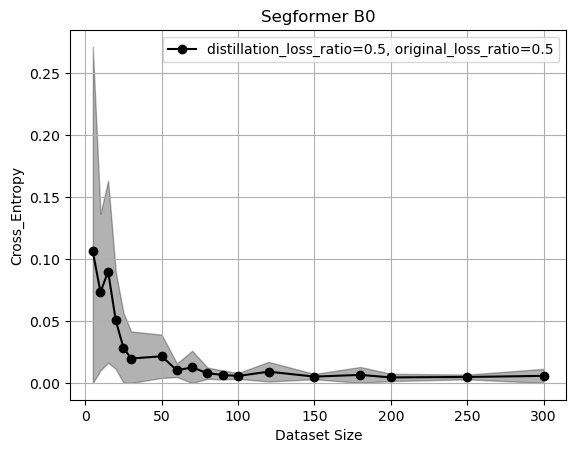

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()